In [1]:
pip install tensorflow

In [2]:
pip install numpy

In [3]:
pip install pillow

In [4]:
pip install keras

In [5]:
pip install matplotlib

In [6]:
# All import statements
import tensorflow as tf
import keras
import numpy as np
import os
import gzip
import matplotlib.pyplot as plt
import pickle
from numpy import unique, argmax
from keras.datasets.mnist import load_data
from keras import Sequential
from keras.models import Model
from keras.layers import Conv2D, MaxPool2D, Dense
from keras.layers import Flatten, Dropout
from keras.utils import plot_model
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

# Just checking the version
# Because a lot of compatibility issues
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print(f"NumPy version: {np.__version__}")

TensorFlow version: 2.14.0
Keras version: 2.14.0
NumPy version: 1.23.5


In [7]:
# LOADING and PREPROCESSING the MNIST datasets

# We load the Standard MNIST dataset
# spliting the dataset
(x_train, y_train), (x_test, y_test) = load_data()

# Reshaping the training and testing data
# We are reshaphing the MNIST dataset to greyscale
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))

# Normalizing the values of the pixels of the images
# We do this so all pixels values of each image in the dataset are unsigned integers in the range of 0 to 255
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0


In [8]:
# Expanding the Dataset little more
# Augmenting the Dataset by shifting the position of the images

# Function to Augument the Dataset

def augment_dataset(x,y):
  # Utilize the ImageDataGenerator to shift the image
  shift = 1.0 /28 # because the images are 28x28 pixels
  datagen = ImageDataGenerator(width_shift_range=shift, height_shift_range=shift)

  # Initializing empty arrays to store the augmented images and labels
  augmented_images = []
  augmented_labels = []

  # Augment all the images in the dataset
  for i in range(len(x)):
    # Reshaping the image
    image = x[i].reshape((1,)+ x[i].shape)

    # Apply four shifts to each image (up, down, left, right)
    for shift in ['right', 'left', 'up', 'down']:
        # Configure the datagen for the specific shift
        if shift == 'right':
            datagen.width_shift_range = -1.0 / 28
            datagen.height_shift_range = 0
        elif shift == 'left':
            datagen.width_shift_range = 1.0 / 28
            datagen.height_shift_range = 0
        elif shift == 'up':
            datagen.width_shift_range = 0
            datagen.height_shift_range = 1.0 / 28
        elif shift == 'down':
            datagen.width_shift_range = 0
            datagen.height_shift_range = -1.0 / 28

        # Generate augmented images (just one in this case)
        for x_aug in datagen.flow(image, batch_size=1):
            augmented_images.append(x_aug[0])
            augmented_labels.append(y[i])
            break  # we only want to augment the image once per shift

  # Convert the lists to numpy arrays
  augmented_images = np.array(augmented_images)
  augmented_labels = np.array(augmented_labels)

  return augmented_images, augmented_labels


In [9]:
augmented_x_train, augmented_y_train = augment_dataset(x_train, y_train)
augmented_x_test, augmented_y_test = augment_dataset(x_test, y_test)

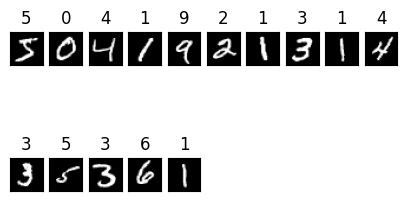

In [10]:
fig = plt.figure(figsize=(5,3))
for i in range(15):
  ax = fig.add_subplot(2,10, i+1, xticks=[], yticks=[])
  ax.imshow(np.squeeze(x_train[i]), cmap='gray')
  ax.set_title(y_train[i])

In [11]:
# Checking the shape of the input images
# 28x28 pixels grayscales
img_shape = x_train.shape[1:]
print(img_shape)

(28, 28, 1)


In [12]:
# Defining the CNN model we are going to use
# Sequential
model = Sequential()

# Adding the Convolutional Layer
# Using the Rectified Linear Unit activation function
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)))
model.add(BatchNormalization()) # To stabalize and speed up the training process
model.add(MaxPool2D((2,2)))
model.add(Conv2D(48, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))
#model.add(Conv2D(256, (3,3), activation='relu'))
#model.add(BatchNormalization())
#model.add(MaxPool2D((2,2)))


model.add(Flatten())
# Network layer has 500 nodes
model.add(Dense(500, activation='relu'))
# Dropping 50% of the weights
model.add(Dropout(0.5))
# Output layer has just 10 nodes
model.add(Dense(10, activation='softmax'))

In [13]:
# Checking the model Summary
# Understanding the build
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 batch_normalization (Batch  (None, 26, 26, 32)        128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 48)        13872     
                                                                 
 batch_normalization_1 (Bat  (None, 11, 11, 48)        192       
 chNormalization)                                                
                                                        

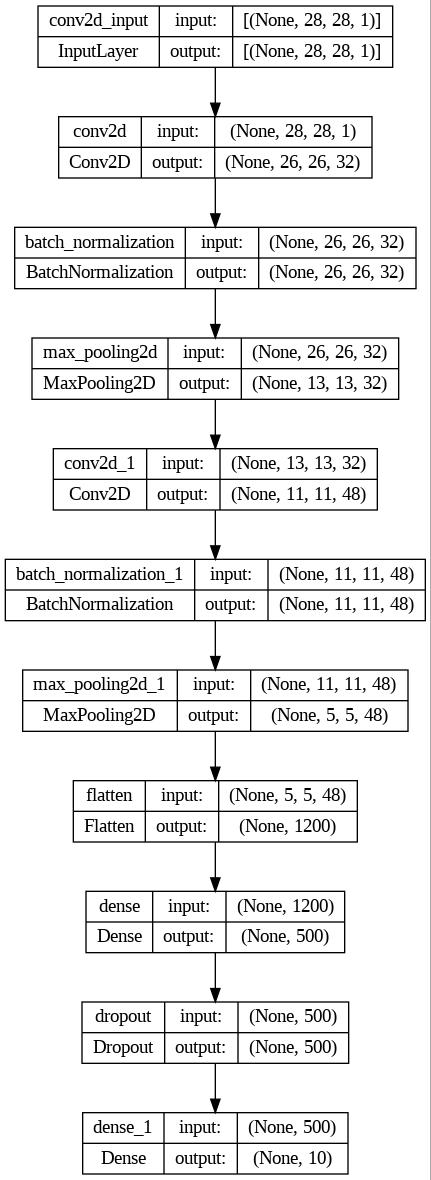

In [14]:
# How the model looks
# Looking at the Layers
plot_model(model, 'model.jpg', show_shapes=True)

In [15]:
# Now comes the tricky part
# Training the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
#model.fit(x_train_combined, y_train_combined, epochs=10, batch_size=128, verbose=2, validation_split=0.1)
model.fit(x_train, y_train, epochs=10, batch_size=128, verbose=2, validation_split=0.1)

Epoch 1/10
422/422 - 70s - loss: 0.1706 - accuracy: 0.9494 - val_loss: 0.1837 - val_accuracy: 0.9437 - 70s/epoch - 166ms/step
Epoch 2/10
422/422 - 64s - loss: 0.0591 - accuracy: 0.9816 - val_loss: 0.0408 - val_accuracy: 0.9880 - 64s/epoch - 152ms/step
Epoch 3/10
422/422 - 64s - loss: 0.0438 - accuracy: 0.9866 - val_loss: 0.0428 - val_accuracy: 0.9878 - 64s/epoch - 151ms/step
Epoch 4/10
422/422 - 60s - loss: 0.0360 - accuracy: 0.9886 - val_loss: 0.0352 - val_accuracy: 0.9905 - 60s/epoch - 142ms/step
Epoch 5/10
422/422 - 60s - loss: 0.0315 - accuracy: 0.9901 - val_loss: 0.0396 - val_accuracy: 0.9905 - 60s/epoch - 142ms/step
Epoch 6/10
422/422 - 60s - loss: 0.0272 - accuracy: 0.9917 - val_loss: 0.0466 - val_accuracy: 0.9902 - 60s/epoch - 143ms/step
Epoch 7/10
422/422 - 60s - loss: 0.0270 - accuracy: 0.9916 - val_loss: 0.0382 - val_accuracy: 0.9915 - 60s/epoch - 142ms/step
Epoch 8/10
422/422 - 60s - loss: 0.0241 - accuracy: 0.9929 - val_loss: 0.0450 - val_accuracy: 0.9923 - 60s/epoch - 142

In [16]:
model.save('my_model.h5')  # Saves the model as 'my_model.h5'

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [17]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f'Accuracy: {accuracy*100}%')

Accuracy: 98.87999892234802%


In [18]:
# Saving the model in Pickle
pickle.dump(model, open('model.pk1','wb'))

model = pickle.load(open('model.pk1','rb'))

1/1 [==============================] - 0s 110ms/step


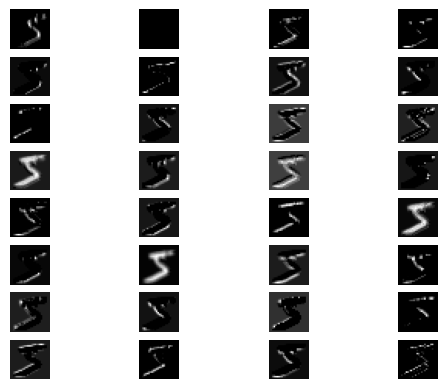

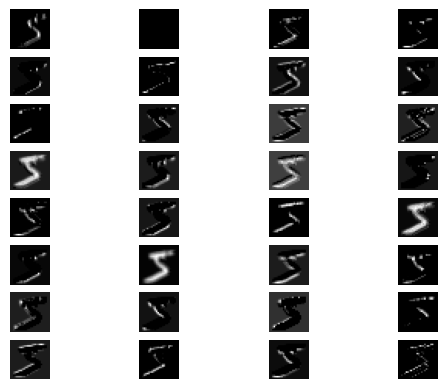

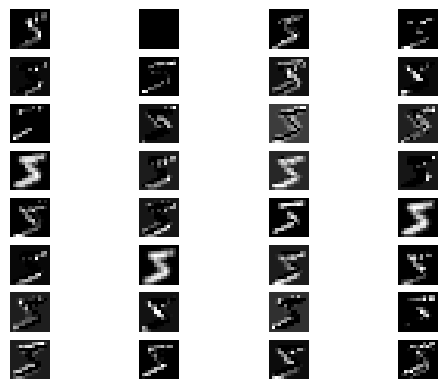

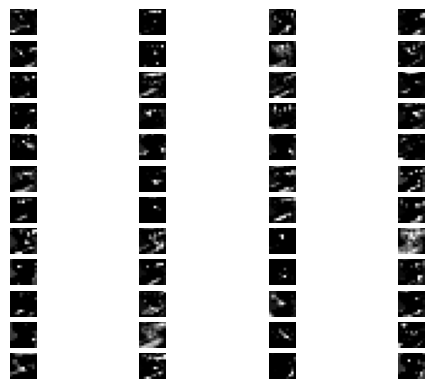

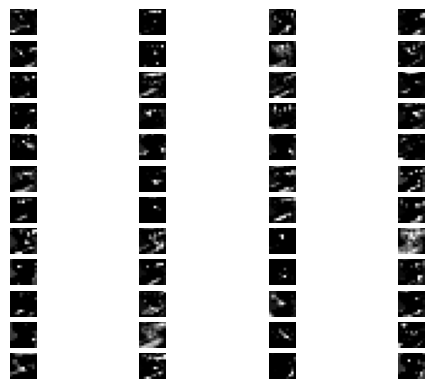

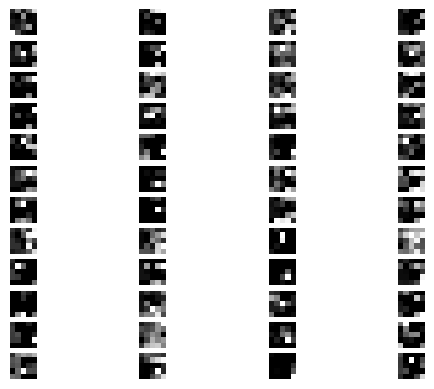

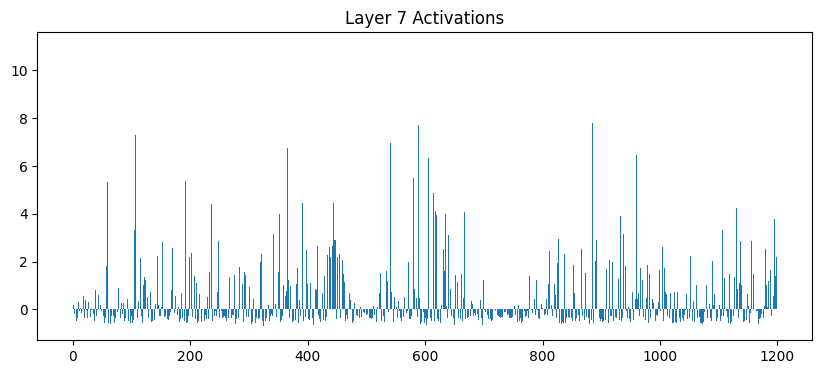

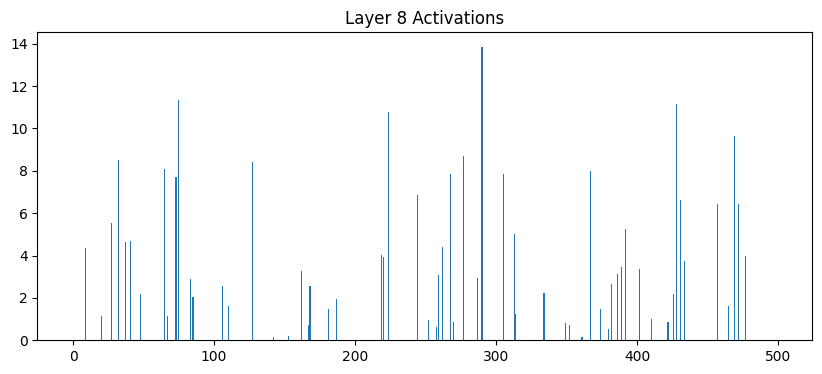

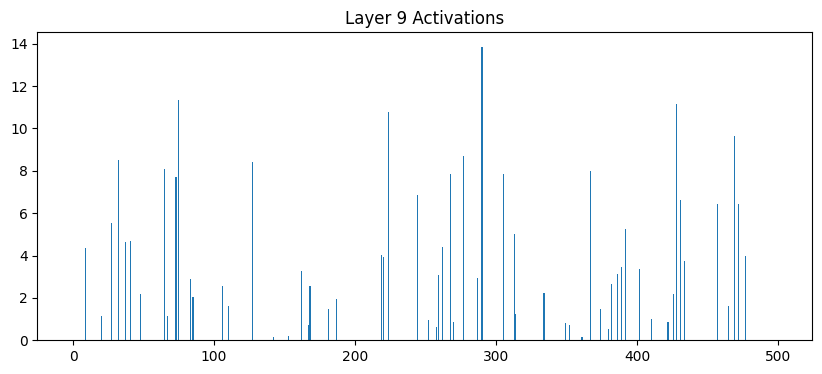

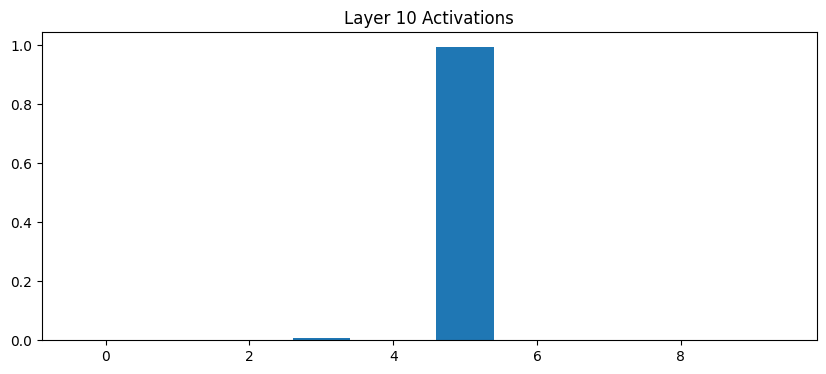

In [22]:
# To extract and display intermediate layer outputs

model = model
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)


def display_layer_activations(layer_activations, image):
    activation_values = activation_model.predict(image)
    #max_channels_to_display = 32
    for i, activation_value in enumerate(activation_values):
      if len (activation_value.shape) ==4:
        channels = activation_value.shape[-1]
        rows = channels // 4
        cols =4
       # channels = min(channels, max_channels_to_display)
        #cols = 8
        #rows = channels // cols + (channels % cols > 0)  # Display up to 4 channels per row
        #plt.figure(figsize=(cols *2, rows *2))
        for j in range(channels):
            ax = plt.subplot(rows, cols, j + 1)
            ax.imshow(activation_value[0, :, :, j], cmap='gray')  # Use 'gray' colormap for greyscale
            ax.axis('off')
        plt.show()
      elif len(activation_value.shape) == 2:
            # This is for Dense Layers
            # Example: Just plot the activation values as a bar chart
          plt.figure(figsize=(10, 4))
          plt.bar(range(len(activation_value[0])), activation_value[0])
          plt.title(f"Layer {i+1} Activations")
          plt.show()

# Display intermediate layer activations for a sample image (e.g., the first image in the training set)
sample_image = x_train[0].reshape(1, 28, 28, 1)
display_layer_activations(layer_outputs, sample_image)

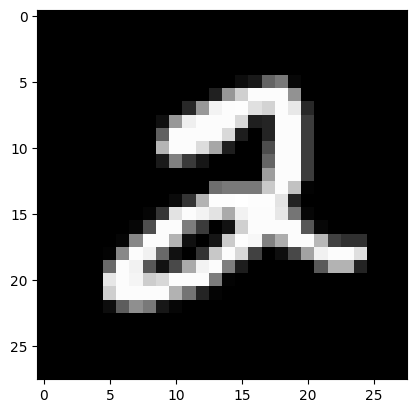

In [19]:
# Time to validate our prediction
# We first display the Image we want to validate our prediction on
image = x_train[5]
plt.imshow(np.squeeze(image), cmap='gray')
plt.show()

In [20]:
# now we check if the predicted label and the image is correct or not
image= image.reshape(1, image.shape[0], image.shape[1], image.shape[2])
prediction = model.predict([image])
print('Image Prediction: {}'.format(argmax(prediction)))

1/1 [==============================] - 0s 125ms/step
Image Prediction: 2


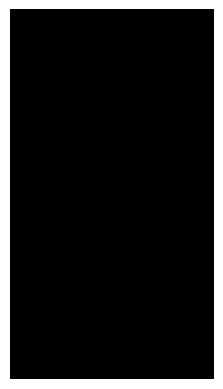

1/1 [==============================] - 0s 24ms/step
Model Prediction: 1


In [23]:
# Practising to take images as inputs and predict its accuracy

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Function to preprocess the user-uploaded image
def preprocess_user_image(image_path, target_size=(28, 28)):
    # Open the image file
    user_image = Image.open(image_path).convert('L')  # Convert to grayscale
    # Resize the image to the target size
    user_image = user_image.resize(target_size)
    # Convert the image to a NumPy array
    user_image_array = np.array(user_image)
    # Reshape the array to match the model's input shape
    user_image_array = user_image_array.reshape(1, target_size[0], target_size[1], 1)
    # Normalize pixel values to be in the range [0, 1]
    user_image_array = user_image_array.astype('float32') / 255.0

    return user_image_array

# Function to display the user-uploaded image
def display_user_image(image_path):
    user_image = Image.open(image_path).convert('L')
    plt.imshow(user_image, cmap='gray')
    plt.axis('off')
    plt.show()

# Get the path to the user-uploaded image
#user_image_path = input("Enter the path to your handwritten image file: ")
user_image_path = "1.png"

# Display the user-uploaded image
display_user_image(user_image_path)

# Preprocess the user-uploaded image
preprocessed_user_image = preprocess_user_image(user_image_path)

# Make predictions using the trained model
predictions = model.predict(preprocessed_user_image)

# Display the model's prediction
predicted_digit = np.argmax(predictions)
print(f'Model Prediction: {predicted_digit}')
